In [13]:
import pandas as pd
import numpy as np
import re  
import statsmodels.api as sm
import statsmodels.formula.api as smf
#plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

In [14]:
# Read the CSV file
data_RAAM_raw = pd.read_csv("Data_AkrongAndMcGahan.csv")
data_RAAM_raw


,library,B1_1,B2_1,B1_2,B2_2,aa,pos,mut
0,36062,28493,30860,93150,58496,NaN,-1,NaN
1,1401,7067,1274,43195,46,T,145,S
2,1304,82,319,2163,1778,T,145,L
3,1256,0,0,16,0,T,145,P
4,1203,46,1063,434,0,G,148,L
...,...,...,...,...,...,...,...,...
424,11,0,0,0,0,L,151,Y
425,10,0,0,0,0,R,153,D
426,10,0,19,86,12,P,146,T
427,0,0,90,0,0,S,158,N


In [15]:
def formula(df, B1_col, B2_col):
    df = df[(df['library'] != 0) & ((df[B1_col] != 0) | (df[B2_col] != 0))] #remove rows that b1,b2 = 0 and library = 0
    df=df.applymap(lambda x: 0.1 if x == 0 else x) #value  0 -> 0.1
    
    df['B1dMut'] = (df[B1_col] / df[B1_col].iloc[0]) / (df['library'] / df['library'].iloc[0])
    df['B2dMut'] = (df[B2_col] / df[B2_col].iloc[0]) / (df['library'] / df['library'].iloc[0])
    df['changeB2_B1'] = df['B2dMut'] - df['B1dMut']
    
    return df[['pos', 'mut', 'changeB2_B1']]


In [16]:
RAAM_1 = formula(data_RAAM_raw[['pos', 'mut', 'B1_1', 'B2_1', 'library']].copy(), 'B1_1', 'B2_1')
RAAM_2 = formula(data_RAAM_raw[['pos', 'mut', 'B1_2', 'B2_2', 'library']].copy(), 'B1_2', 'B2_2')

data_RAAM = pd.concat([RAAM_1, RAAM_2]).sort_values(by='pos')
data_RAAM['pos'] = data_RAAM['pos'].astype(str)
data_RAAM['mut'].fillna('*', inplace=True)

data_RAAM

,pos,mut,changeB2_B1
0,-1,*,0.000000
0,-1,*,0.000000
226,136,S,-0.080901
289,136,T,-3.270944
285,136,D,0.001655
...,...,...,...
329,158,Y,-0.154810
53,158,R,-2.060509
302,158,C,-3.817117
72,158,V,-0.549014


In [17]:
model = smf.glm('changeB2_B1 ~ C(pos, Treatment(reference="-1")) * mut', data=data_RAAM).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            changeB2_B1   No. Observations:                  366
Model:                            GLM   Df Residuals:                      120
Model Family:                Gaussian   Df Model:                          245
Link Function:               identity   Scale:                          28.934
Method:                          IRLS   Log-Likelihood:                -927.70
Date:                Fri, 20 Oct 2023   Deviance:                       3408.9
Time:                        10:01:39   Pearson chi2:                 3.41e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.6994
Covariance Type:            nonrobust                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [18]:
# extract coef and p value from OLS output
coefficients = model.params[44:]
p_values = model.pvalues[44:]

# extract predictors from OLS output
predictors = model.params.index[44:]

# extract pos and mut values
pos_list =[]
mut_list =[]
for pre in predictors:
    pos_match = re.search(r'\[T.(\d+)\]', pre)
    pos_list.append(pos_match.group(1))
    
    mut_match = re.search(r'mut\[T.(.*)\]', pre) 
    mut_list.append(mut_match.group(1))
    
#DataFrame with the extracted data
ols_results = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values, 'Position':pos_list, 'Mutation': mut_list})

# custom mutation order #can group amino acid to (+)(-)aromatic...
mut_order = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'][::-1]
ols_results['Mutation'] = pd.Categorical(ols_results['Mutation'], categories=mut_order, ordered=True)

ols_results

,Coefficient,P-Value,Position,Mutation
"C(pos, Treatment(reference=""-1""))[T.136]:mut[T.A]",4.014741e-01,0.912495,136,A
"C(pos, Treatment(reference=""-1""))[T.137]:mut[T.A]",3.919900e+00,0.577030,137,A
"C(pos, Treatment(reference=""-1""))[T.138]:mut[T.A]",-7.056507e-16,0.966824,138,A
"C(pos, Treatment(reference=""-1""))[T.139]:mut[T.A]",6.922765e-01,0.893346,139,A
"C(pos, Treatment(reference=""-1""))[T.140]:mut[T.A]",1.394960e+00,0.748314,140,A
...,...,...,...,...
"C(pos, Treatment(reference=""-1""))[T.154]:mut[T.Y]",0.000000e+00,NaN,154,Y
"C(pos, Treatment(reference=""-1""))[T.155]:mut[T.Y]",0.000000e+00,NaN,155,Y
"C(pos, Treatment(reference=""-1""))[T.156]:mut[T.Y]",0.000000e+00,NaN,156,Y
"C(pos, Treatment(reference=""-1""))[T.157]:mut[T.Y]",0.000000e+00,NaN,157,Y


In [19]:
def get_alpha(p):
  if 0 < p < 0.001:
    return '***'
  elif 0.001< p < 0.01:
    return '**' 
  elif 0.01 < p < 0.05:
    return '*'
  elif 0.05 < p < 0.1:
    return '.'
  else:
    return ' '
  
ols_results['alpha'] = ols_results['P-Value'].apply(get_alpha)
ols_results

,Coefficient,P-Value,Position,Mutation,alpha
"C(pos, Treatment(reference=""-1""))[T.136]:mut[T.A]",4.014741e-01,0.912495,136,A,
"C(pos, Treatment(reference=""-1""))[T.137]:mut[T.A]",3.919900e+00,0.577030,137,A,
"C(pos, Treatment(reference=""-1""))[T.138]:mut[T.A]",-7.056507e-16,0.966824,138,A,
"C(pos, Treatment(reference=""-1""))[T.139]:mut[T.A]",6.922765e-01,0.893346,139,A,
"C(pos, Treatment(reference=""-1""))[T.140]:mut[T.A]",1.394960e+00,0.748314,140,A,
...,...,...,...,...,...
"C(pos, Treatment(reference=""-1""))[T.154]:mut[T.Y]",0.000000e+00,NaN,154,Y,
"C(pos, Treatment(reference=""-1""))[T.155]:mut[T.Y]",0.000000e+00,NaN,155,Y,
"C(pos, Treatment(reference=""-1""))[T.156]:mut[T.Y]",0.000000e+00,NaN,156,Y,
"C(pos, Treatment(reference=""-1""))[T.157]:mut[T.Y]",0.000000e+00,NaN,157,Y,


In [20]:
#custom color map

top_color = (0 / 255, 139 / 255, 139 / 255)  #yellow
bottom_color = (255 / 255, 185 / 255, 15 / 255) #cyan

# set the position for the white color (where Coefficient = 0)
middle_position = abs(0 - min(ols_results['Coefficient'])) / (max(ols_results['Coefficient']) - min(ols_results['Coefficient']))
colors = [top_color, (1, 1, 1), bottom_color]
positions = [0.0, middle_position, 1.0]

custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', list(zip(positions, colors)))


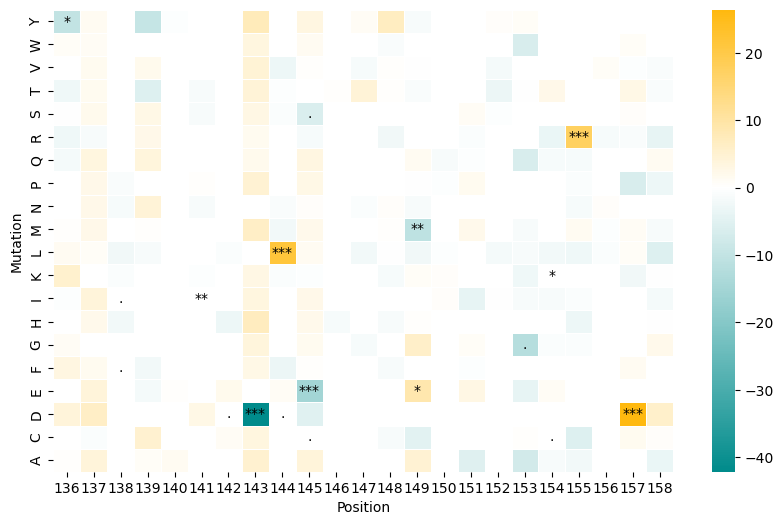

In [23]:
# Pivot the data
heatmap_data = ols_results.pivot_table(index='Mutation', columns='Position', values='Coefficient')

#the heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, cmap=custom_cmap, linewidths=.5,fmt=".2f", cbar=True)

#add 'alpha' values to the heatmap
for i, row in enumerate(heatmap_data.index):
    for j, col in enumerate(heatmap_data.columns):
        alpha_value =ols_results[(ols_results['Mutation'] == row) & (ols_results['Position'] == col)]['alpha'].values[0]
        heatmap.text(j + 0.5, i + 0.5, alpha_value, ha='center', va='center', color='black')

plt.xlabel("Position")
plt.ylabel("Mutation")
plt.show()